In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [19]:
'''
    对矩阵X进行旋转变换
    X.shape = (D, N)
    theta为旋转的弧度
    axis为旋转的轴，合法值为'x','y'或'z'
'''
def rotate(X, theta=0, axis='x'):
    if axis == 'x':
        rotate = [[1, 0, 0], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]]
        return np.dot(rotate, X)
    elif axis == 'y':
        rotate = [[np.cos(theta), 0, np.sin(theta)], [0, 1, 0], [-np.sin(theta), 0, np.cos(theta)]]
        return np.dot(rotate, X)
    elif axis == 'z':
        rotate = [[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]]
        return np.dot(rotate, X)
    else:
        print('错误的旋转轴')
        return X

In [20]:
'''
    生成瑞士卷数据
    n_sample，生成的数据点数量，default=100
    noise，生成数据点的噪声程度，default=0.0
    y_scale，瑞士卷的厚度，default=100
'''
def make_swiss_roll(n_sample=100, noise=0.0, y_scale=100):
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(1, n_sample))
    x = t * np.cos(t)
    y = y_scale * np.random.rand(1, n_sample)
    z = t * np.sin(t)
    X = np.concatenate((x, y, z))
    X += noise * np.random.randn(3, n_sample)
    X = rotate(X, 40 * np.pi / 180, 'z') # 绕x轴旋转数据点20°
    X = X.T
    return X

In [21]:
def show_3D(X):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.view_init(elev=20, azim=80)
    ax.scatter(X[:,0], X[:,1], X[:,2], c=X[:,0], cmap=plt.cm.gnuplot)
    ax.legend(loc='best')
    plt.show()

In [22]:
def show_2D(X):
    plt.scatter(X[:,0].tolist(), X[:,1].tolist(), c=X[:,0].tolist(), cmap=plt.cm.gnuplot)
    plt.show

In [23]:
'''
    对数据data用PCA降至k维
    data.shape = (N, D)
    返回值：
    c_data，中心化数据，shape=(N, D)
    eigVectsReduce，特征向量矩阵，shape=(D, k)
    data_mean，降维前数据均值，shape=(1, D)
'''
def PCA(data, k):
    rows, cols = data.shape 
    data_mean = np.sum(data, 0) / rows
    c_data = data - data_mean # 中心化
    covMat = np.dot(c_data.T, c_data)
    eigVals, eigVects = np.linalg.eig(covMat) # 对协方差矩阵(D,D)求特征值和特征向量
    eigValIndex = np.argsort(eigVals) # 特征值排序
    eigVectsReduce = eigVects[:,eigValIndex[:-(k+1):-1]] # 取前k个特征值对应的特征向量
    return c_data, eigVectsReduce, data_mean

In [24]:
'''
    人工数据PCA实验
'''
def self_exp(X):
    show_3D(X)
    c_data, eigVectsReduce, data_mean = PCA(X, 2)
    pca_data = np.dot(c_data, eigVectsReduce)
    show_2D(pca_data)

No handles with labels found to put in legend.


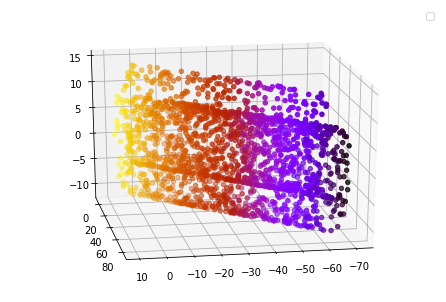

No handles with labels found to put in legend.


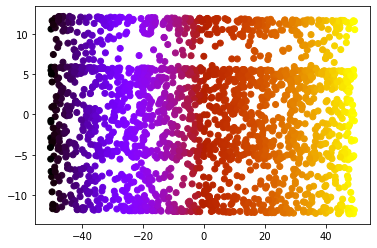

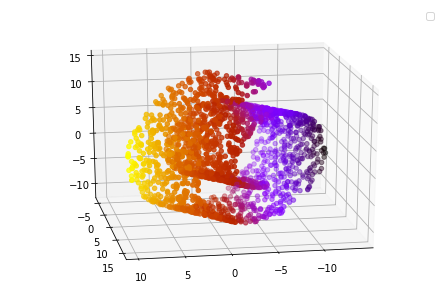

No handles with labels found to put in legend.


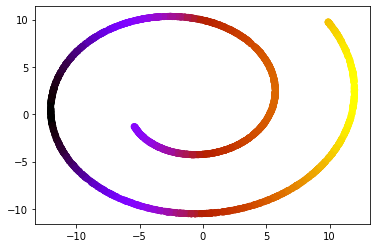

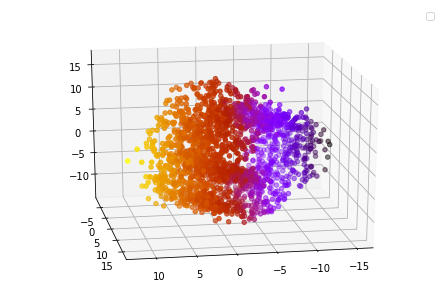

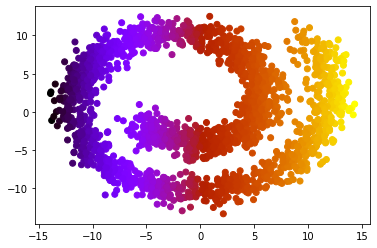

In [25]:
X1 = make_swiss_roll(2000, 0, 100)
X2 = make_swiss_roll(2000, 0, 10)
X3 = make_swiss_roll(2000, 1, 10)
self_exp(X1)
self_exp(X2)
self_exp(X3)

In [26]:
import os
import matplotlib.image as mpimg
import cv2
from PIL import Image
import math
size = (40, 40) # 由于较大的数据在求解特征值和特征向量时很慢，故统一压缩图像为size大小

In [27]:
'''
    从file_path中读取面部图像数据
'''
def read_faces(file_path):
    file_list = os.listdir(file_path)
    data = []
    i = 1
    plt.figure(figsize=size)
    for file in file_list:
        path = os.path.join(file_path, file)
        plt.subplot(3, 4, i)
        with open(path) as f:
            img = cv2.imread(path) # 读取图像
            img = cv2.resize(img, size) # 压缩图像至size大小
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # 三通道转换为灰度图
            plt.imshow(img_gray) # 预览
            h, w = img_gray.shape
            img_col = img_gray.reshape(h * w) # 对(h,w)的图像数据拉平
            data.append(img_col)
        i += 1
    plt.show()
    return np.array(data)

In [28]:
'''
    计算峰值信噪比psnr
'''
def psnr(img1, img2):
   mse = np.mean((img1 / 255. - img2 / 255.) ** 2 )
   if mse < 1.0e-10:
      return 100
   PIXEL_MAX = 1
   return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

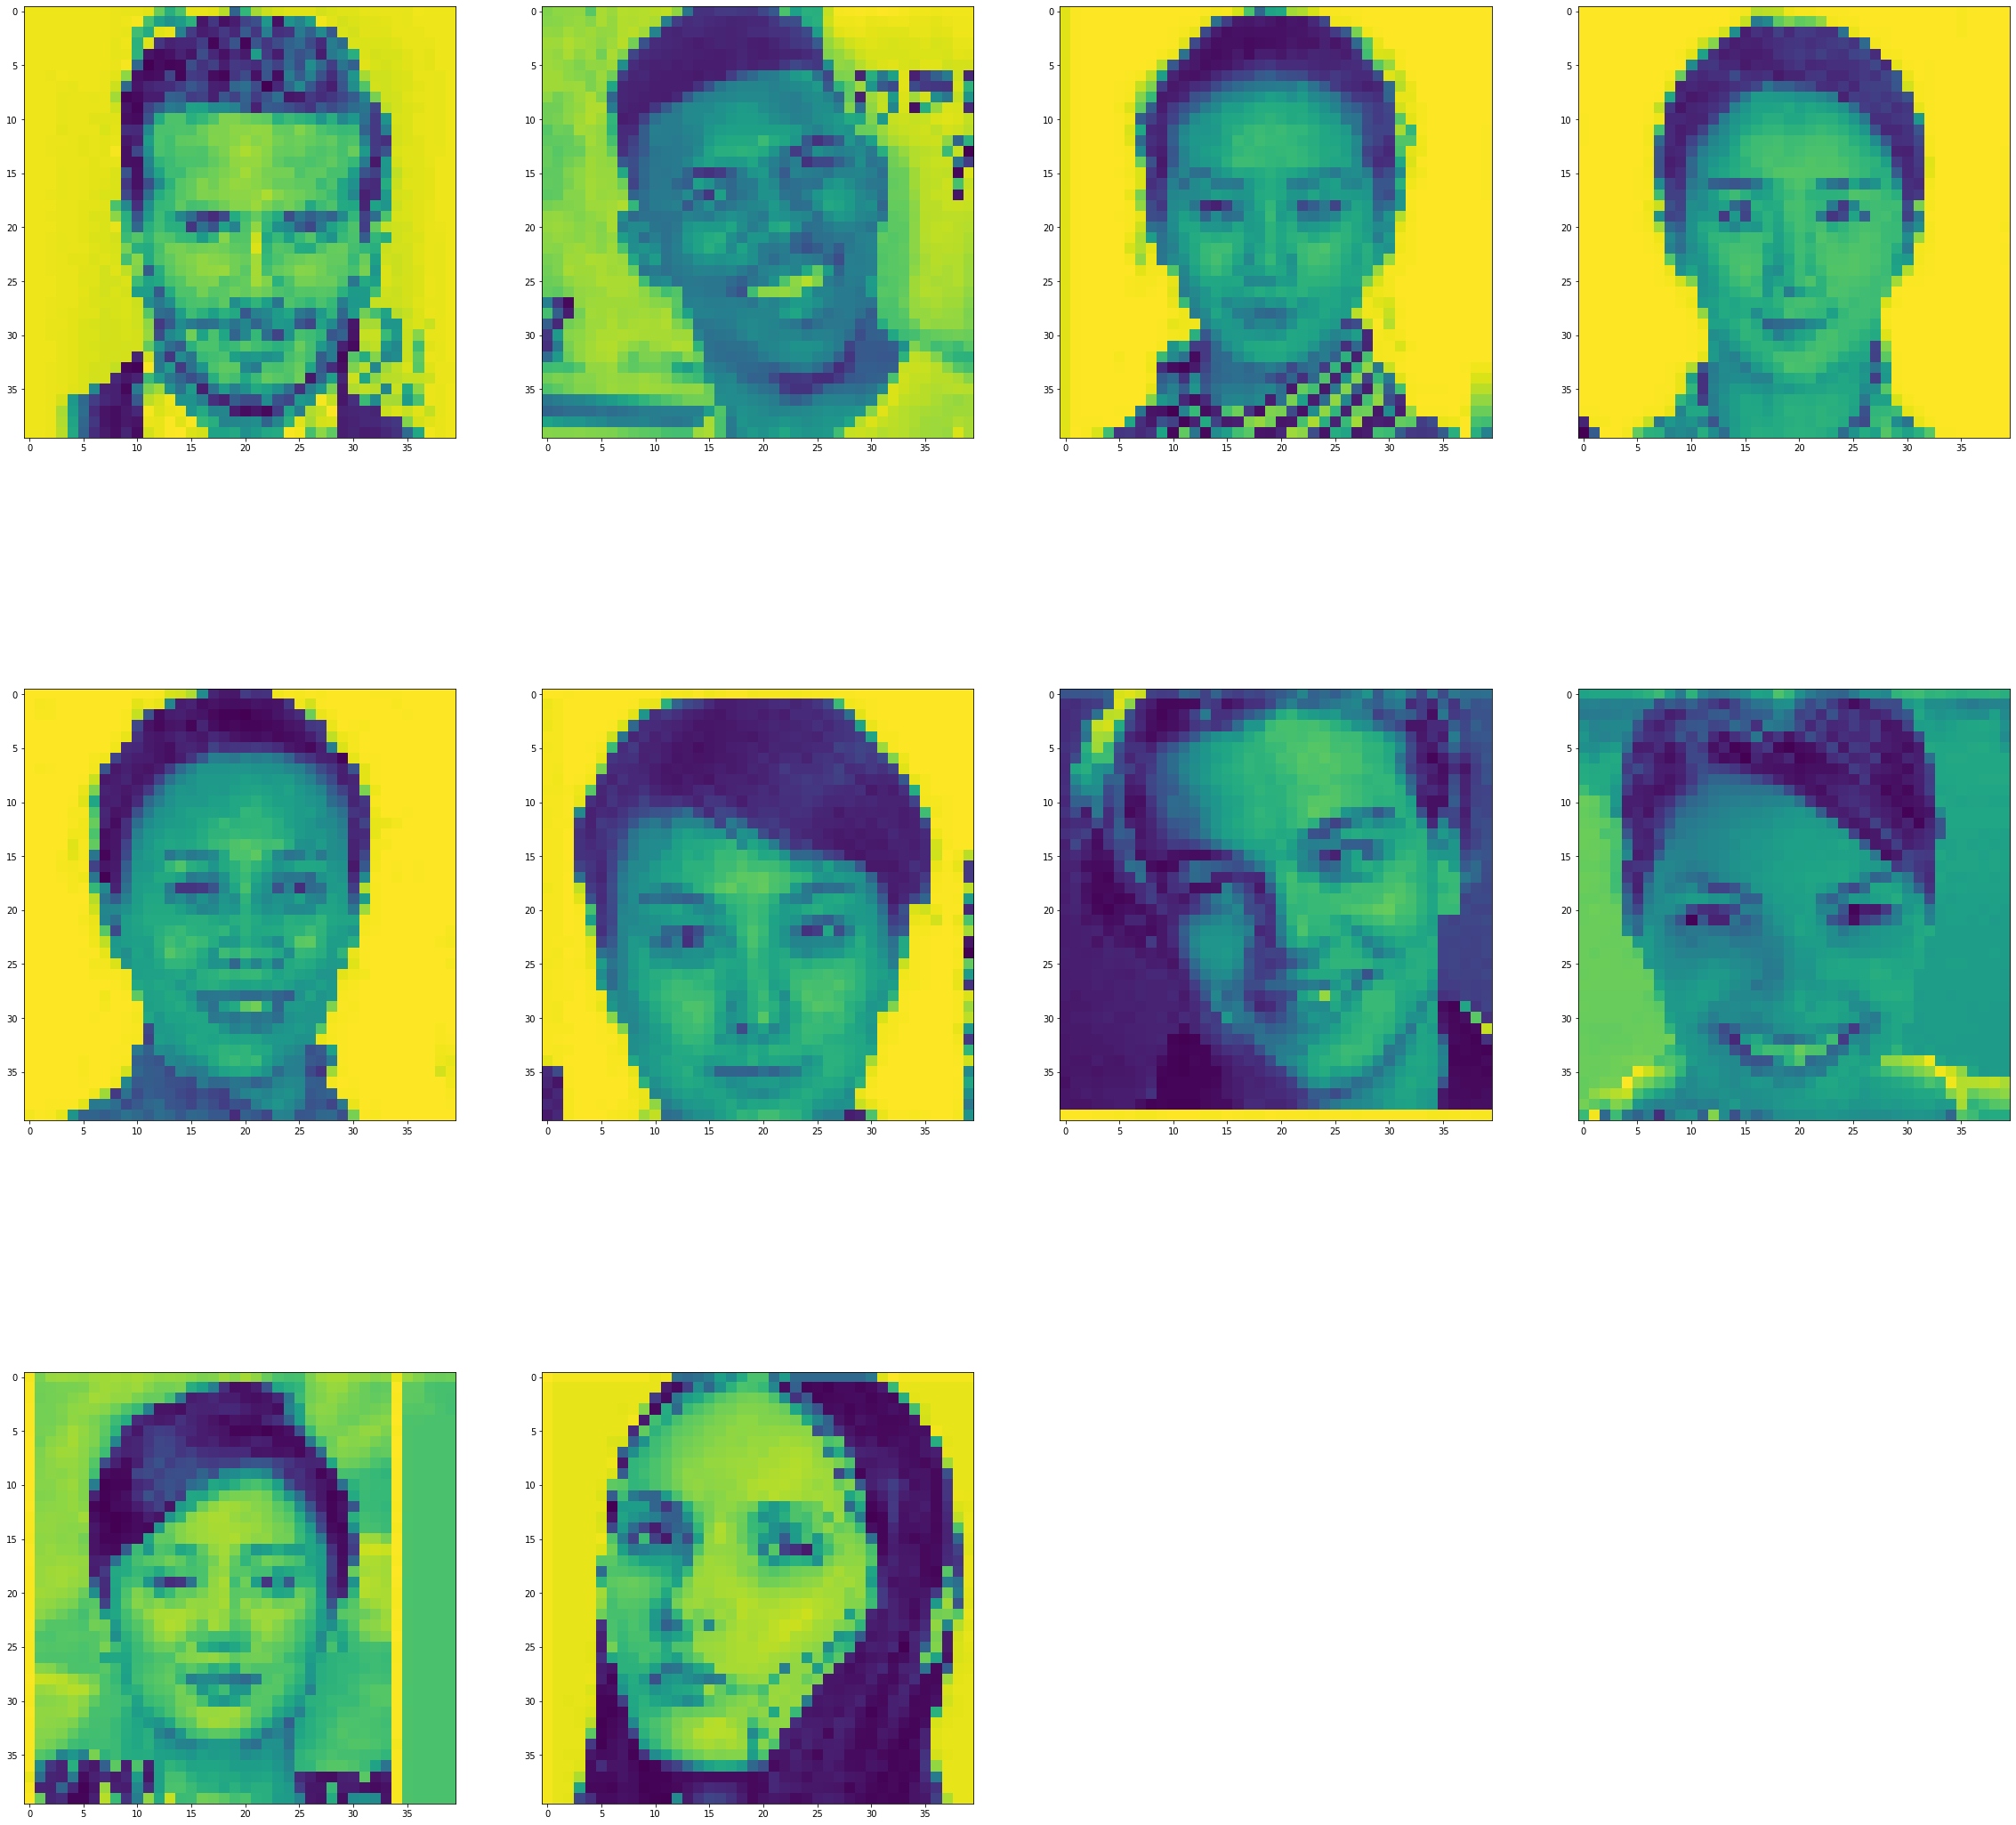

In [29]:
data = read_faces('PCA-FACE')

[[-0.02828862+0.j]
 [-0.02843404+0.j]
 [-0.02870088+0.j]
 ...
 [-0.00552083+0.j]
 [ 0.00191002+0.j]
 [ 0.00654576+0.j]]


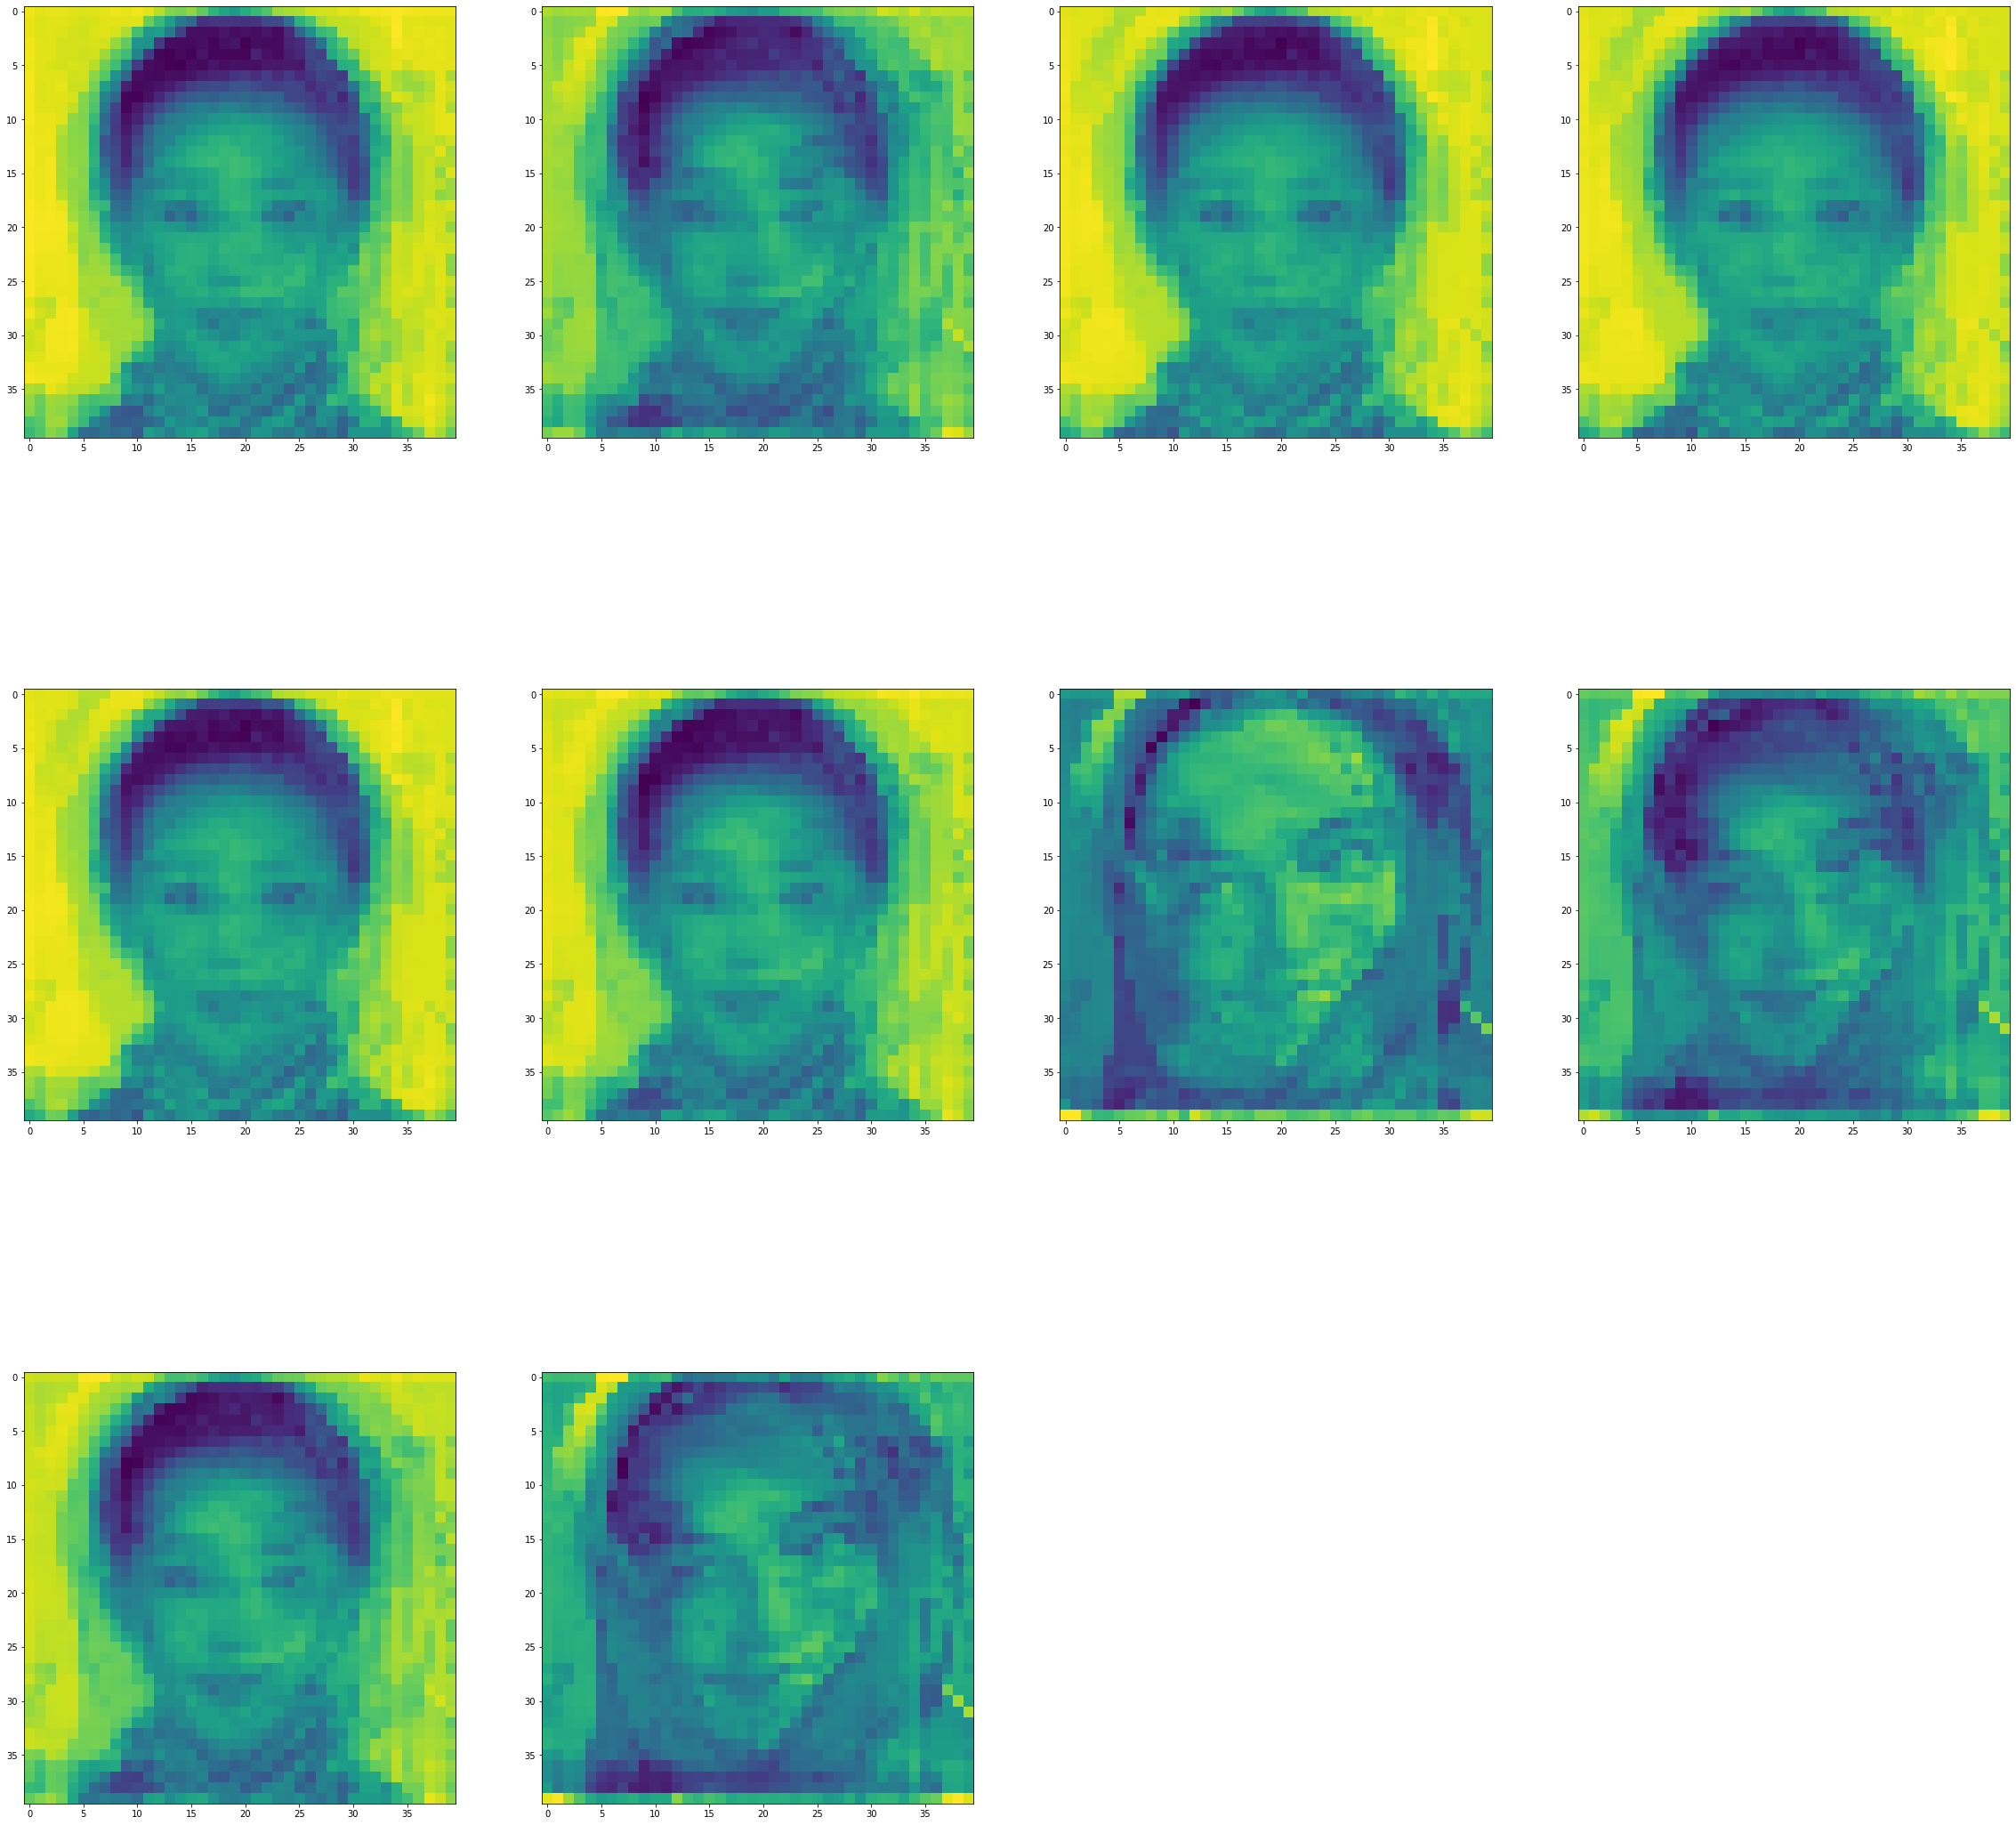

In [42]:
n_samples, n_features = data.shape
c_data, eigVectsReduce, data_mean = PCA(data, 1) # PCA降维
print(eigVectsReduce)
eigVectsReduce = np.real(eigVectsReduce) # 一旦降维维度超过某个值，特征向量矩阵将出现复向量，对其保留实部
pca_data = np.dot(c_data, eigVectsReduce) # 计算降维后的数据
recon_data = np.dot(pca_data, eigVectsReduce.T) + data_mean # 重构数据
plt.figure(figsize=size)
for i in range(n_samples):
    plt.subplot(3,4,i+1)
    plt.imshow(recon_data[i].reshape(size))
plt.show()


In [43]:
print("信噪比如下：")
for i in range(n_samples):
    a = psnr(data[i], recon_data[i])
    print('图', i, '的信噪比: ', a)

信噪比如下：
图 0 的信噪比:  14.471213830525642
图 1 的信噪比:  14.894908823379382
图 2 的信噪比:  17.192307069896465
图 3 的信噪比:  17.659561442661257
图 4 的信噪比:  17.693964235186453
图 5 的信噪比:  13.090294808158605
图 6 的信噪比:  15.522278429142029
图 7 的信噪比:  15.729392099451731
图 8 的信噪比:  14.653351894095398
图 9 的信噪比:  10.364558804486636
